In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import pandas as pd
#from dnn_app_utils_v2 import *
from reg_utils import *
import scipy.io
import math
import sklearn

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Dataset

Given dataset contains:
    - A training set of 37800 images
    - Each image is 28x28 in size

In [2]:
train_data = pd.read_csv("./train.csv")
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*Column "label" is the actual label of an image. Storing "label" column to target(output) and dropping the column later.*

In [3]:
# save the labels to a Pandas series target
num_classes = 10
target = train_data['label']
# Drop the label feature
images = train_data.drop("label",axis=1)
images.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<font color='black' >
 *Each line of images is an image. Following is a visualization of a random image*

(28, 28)


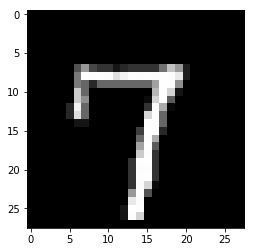

In [4]:
tempImage = images.iloc[[6]]
tempImage = tempImage.as_matrix().reshape(28,28)
print(tempImage.shape)
plt.imshow(tempImage.reshape(28,28))

*Further dividing our actual training data in to train(90%) and cross validation data(10%)*

Also converting pandas data frame to numpy arrays of size(no of features, no of examples). Our train and test data shapes are as follows:
- X_train (784, 37800)
- Y_train (1, 37800)
- X_test (784, 4200)
- Y_test (1, 4200)

In [5]:
# Dividing our actual training data in to train(90%) and test(10%) data
totalimages = images.shape[0]
X_train_orig = images.head(int(totalimages*0.9))
X_train_orig = X_train_orig.as_matrix().T

Y_train_orig = target.head(int(totalimages*0.9))
Y_train_orig = Y_train_orig.as_matrix().reshape(1, Y_train_orig.shape[0])

X_test_orig = images.iloc[int(totalimages*0.9):]
X_test_orig = X_test_orig.as_matrix().T

Y_test_orig = target.iloc[int(totalimages*0.9):]
Y_test_orig = Y_test_orig.as_matrix().reshape(1, Y_test_orig.shape[0])

print (X_train_orig.shape)
print (Y_train_orig.shape)
print (X_test_orig.shape)
print (Y_test_orig.shape)

(784, 37800)
(1, 37800)
(784, 4200)
(1, 4200)


In [6]:
# convert class labels from scalars to one-hot vectors
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]
def dense_to_one_hot(labels_dense, num_classes):
    labels_dense = labels_dense.T
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot.T

train_y = dense_to_one_hot(Y_train_orig, num_classes)
train_y = train_y.astype(np.uint8)
test_y = dense_to_one_hot(Y_test_orig, num_classes)
test_y = test_y.astype(np.uint8)
print (train_y.shape)
print (test_y.shape)


(10, 37800)
(10, 4200)


In [7]:
## Normalize the data
train_x = X_train_orig/255
test_x = X_test_orig/255

print (train_x.shape)
print (train_y.shape)
print (test_x.shape)
print (test_y.shape)

(784, 37800)
(10, 37800)
(784, 4200)
(10, 4200)


In [9]:
### CONSTANTS ###
layers_dims = [784, 20, 7, 5, 10] #  5-layer model


In [9]:
## Batch Gradient descent
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 7, 5, 10]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a4, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a4, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a4, Y)
        else:
            cost = compute_cost_with_regularization(a4, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 500 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 2.303414757520071
Cost after iteration 500: 2.14784763823368
Cost after iteration 1000: 1.9682399080992372
Cost after iteration 1500: 1.7208264501310524
Cost after iteration 2000: 1.536103444122614
Cost after iteration 2500: 1.3546630547557275
Cost after iteration 3000: 1.2136611088924385
Cost after iteration 3500: 1.1132961547151892
Cost after iteration 4000: 1.0341489970238766
Cost after iteration 4500: 0.9655087394750077


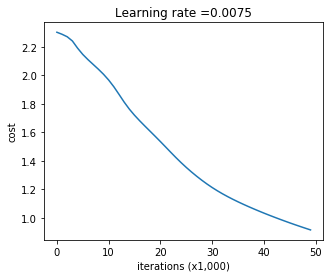

On the training set:
Accuracy: 0.957751322751
On the test set:
Accuracy: 0.962619047619


In [10]:
# Testing Batch gradient descent
parameters = model(train_x, train_y, learning_rate=0.0075, num_iterations = 5000)
print ("On the training set:")
predictions_train = predict(train_x, train_y, parameters)
print ("On the test set:")
predictions_test = predict(test_x, test_y, parameters)

In [8]:
# Utility for Implementing Mini Batch Gradient descent
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((10,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size:(k+1)*mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, (num_complete_minibatches*mini_batch_size): ]
        mini_batch_Y = shuffled_Y[:, (num_complete_minibatches*mini_batch_size): ]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [10]:
## Mini-Batch gradient descent
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, mini_batch_size = 64, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 7, 5, 10]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)
    num_epochs =num_iterations
    seed = 10
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            
            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            if keep_prob == 1:
                a4, cache = forward_propagation(minibatch_X, parameters)
            elif keep_prob < 1:
                a4, cache = forward_propagation_with_dropout(minibatch_X, parameters, keep_prob)

            # Cost function
            if lambd == 0:
                cost = compute_cost(a4, minibatch_Y)
            else:
                cost = compute_cost_with_regularization(a4, minibatch_Y, parameters, lambd)

            # Backward propagation.
            assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                                # but this assignment will only explore one at a time
            if lambd == 0 and keep_prob == 1:
                grads = backward_propagation(minibatch_X, minibatch_Y, cache)
            elif lambd != 0:
                grads = backward_propagation_with_regularization(minibatch_X, minibatch_Y, cache, lambd)
            elif keep_prob < 1:
                grads = backward_propagation_with_dropout(minibatch_X, minibatch_Y, cache, keep_prob)

            # Update parameters.
            parameters = update_parameters(parameters, grads, learning_rate)

        # Print the loss every 10000 iterations
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 2.288171269353432
Cost after iteration 100: 0.7431822154155161
Cost after iteration 200: 0.3126612714662116
Cost after iteration 300: 0.1887235487356645
Cost after iteration 400: 0.18018034256885665
Cost after iteration 500: 0.22052264677608946
Cost after iteration 600: 0.2062349698150152
Cost after iteration 700: 0.12586378304043172
Cost after iteration 800: 0.17189390445639
Cost after iteration 900: 0.1524079114176402
Cost after iteration 1000: 0.03980727868504459
Cost after iteration 1100: 0.13011697319678875
Cost after iteration 1200: 0.03389854615644714
Cost after iteration 1300: 0.17095636939055114
Cost after iteration 1400: 0.12852831180367547
Cost after iteration 1500: 0.055970160308322164
Cost after iteration 1600: 0.03668146310138453
Cost after iteration 1700: 0.019123263821950606
Cost after iteration 1800: 0.05173984186677473
Cost after iteration 1900: 0.06069854451825121


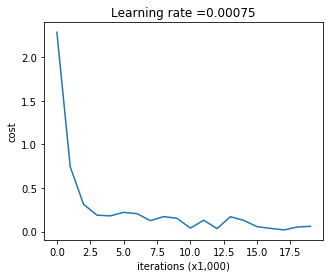

On the training set:
Accuracy: 0.998201058201
On the test set:
Accuracy: 0.988333333333


In [11]:
# Testing Mini batch
parameters = model(train_x, train_y, learning_rate=0.00075, num_iterations = 2000)
print ("On the training set:")
predictions_train = predict(train_x, train_y, parameters)
print ("On the test set:")
predictions_test = predict(test_x, test_y, parameters)